# Gold Price Prediction - LSTM

## Step 1: Importing Libraries


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Step 2: Read data set


In [2]:
df = pd.read_csv('data/Gold Price (2013-2023).csv')

## Step 3: Dataset Overview


In [3]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
...,...,...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


Dataset Basic Information:


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


## Step 4: Data Preparation

### Step 4.1: Feature Subset Selection

Dropping Vol. and Change% because I don't use them:


In [5]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

### Step 4.2: Transforming Data

To increase the speed of calculations, I convert its data type to date time and sort this feature in ascending order:


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

I remove "," sign from the entire dataset and change the data type of the numerical variables to float:


In [7]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

Result:


In [8]:
df.head()

,Date,Price,Open,High,Low
0,2013-01-02,1689.9,1675.8,1695.0,1672.1
1,2013-01-03,1675.6,1688.0,1689.3,1664.3
2,2013-01-04,1649.9,1664.4,1664.4,1630.0
3,2013-01-07,1647.2,1657.3,1663.8,1645.3
4,2013-01-08,1663.2,1651.5,1662.6,1648.8


### Step 4.3: Checking Duplicates

Checking duplicates:


In [9]:
df.duplicated().sum()

np.int64(0)

### Step 4.4: Checking Missing Values

Checking missing values:


In [10]:
df.isnull().sum().sum()

np.int64(0)

## Step 5: Visualizing Gold Price History Data

Interactive Gold Price Chart:


In [ ]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title='Date', yaxis_title='Scaled Price', title={
    'text': 'Gold Price History Data', 'y': 0.95, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
    plot_bgcolor='rgba(255,223,0,0.8)')

## Step 6: Splitting Data to Training & Test Sets

Since I can't train on future data in time series data, I shouldn't divide the time series data randomly. In time series splitting, testing set is always later than training set. I consider the last year for testing and everything else for training:


In [14]:
test_size = df[df.Date.dt.year == 2022].shape[0]
test_size

260

Gold Price Training and Test Sets Plot:


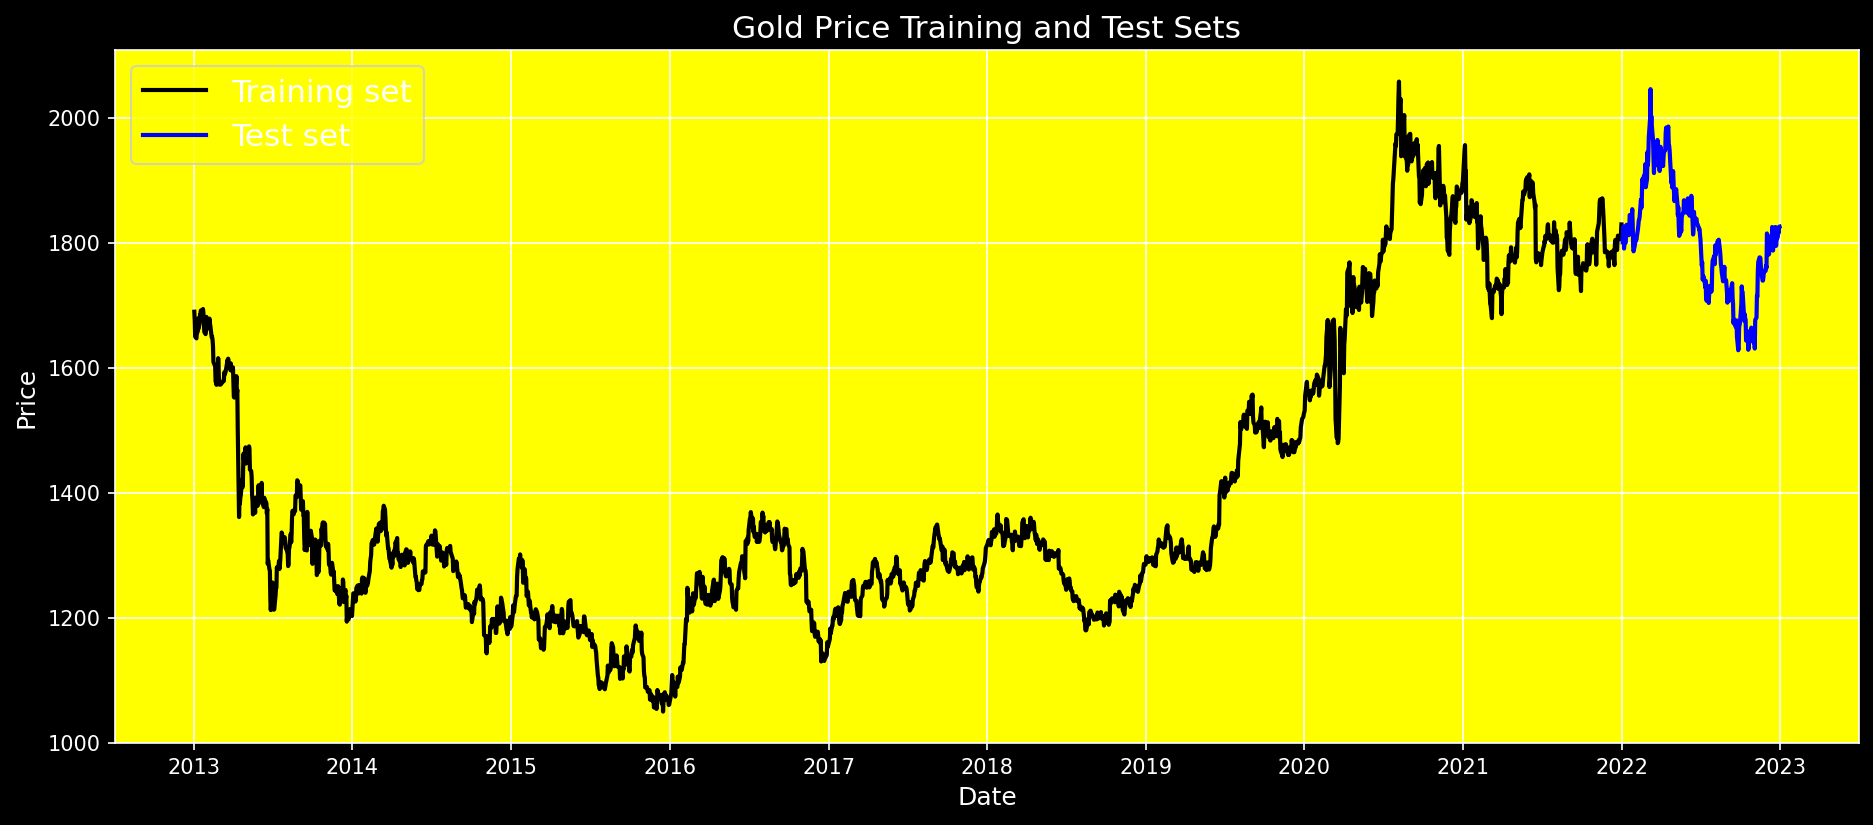

In [15]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes', edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

## Step 7: Data Scaling

I scale Price using MinMaxScaler to avoid intensive computations:


In [31]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1, 1))

MinMaxScaler()

## Step 8: Restructure Data & Create Sliding Window

The use of prior time steps to predict the next step is called sliding window. In this way, time series data can be expressed as supervised learning. I can do this by previous time steps as imput variables and use the next time step as the output variable. The number of previous time steps is called the window width. Here I set window width to 60. Therefore, x_train and x_test will be nested lists containing lists of 60 time_stamp prices. y_train and y_test are also lists of gold prices containing the next day's gold price corresponds to each list in X_train and X_test respectively:


In [32]:
window_size = 60

Training Set:


In [33]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1, 1))

In [34]:
x_train = []
y_train = []

for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

Test Set:


In [35]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1, 1))

In [36]:
x_test = []
y_test = []

for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

## Step 9: Converting Data to Numpy Arrays

Now x_train and x_test are nested lists (2D lists) and y_train is 1D list. I need to convert them to numpy arrays with higher dimension, which is the data format accepted by TensorFlow when training the neural network:


In [37]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [42]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

In [43]:
print('x_train Shape:', x_train.shape)
print('y_train Shape:', y_train.shape)
print('x_test Shape:', x_test.shape)
print('y_test Shape:', y_test.shape)

x_train Shape: (2263, 60, 1)
y_train Shape: (2263, 1)
x_test Shape: (260, 60, 1)
y_test Shape: (260, 1)
